In [4]:
!pip install xgboost --quiet
import numpy as np, pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
np.random.seed(42)


In [5]:
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X.shape, X_train.shape, X_test.shape


((569, 30), (455, 30), (114, 30))

In [6]:
models = {
    "SVM_RBF": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))]),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
                             eval_metric="logloss", random_state=42, n_jobs=-1)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1")
    print(f"{name}: F1 mean={scores.mean():.4f} ± {scores.std():.4f}")


SVM_RBF: F1 mean=0.9820 ± 0.0128
RandomForest: F1 mean=0.9624 ± 0.0100
XGBoost: F1 mean=0.9694 ± 0.0093


Best model: SVM_RBF
Accuracy: 0.9824561403508771
F1: 0.9861111111111112
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



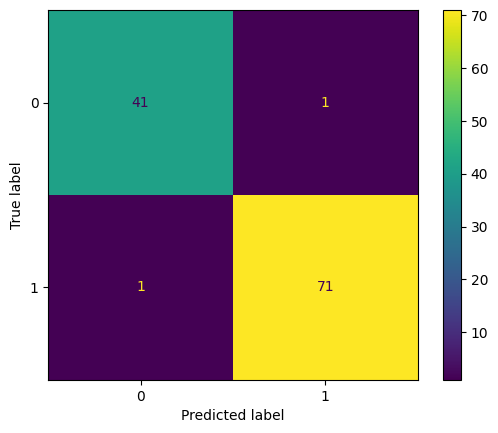

In [7]:
best_name = max(models, key=lambda k: cross_val_score(models[k], X, y, cv=cv, scoring="f1").mean())
best_model = models[best_name].fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Best model:", best_name)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=data.target_names))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()


In [8]:
param_grid = {"clf__C":[0.1,1,10], "clf__gamma":["scale", 0.1, 0.01]}
svm_pipe = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", probability=True))])
grid = GridSearchCV(svm_pipe, param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_, "Best F1:", grid.best_score_)


Best params: {'clf__C': 10, 'clf__gamma': 0.01} Best F1: 0.9809869017218904
